In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as img

from concurrent import futures
import threading
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import math
from collections import Counter

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam



In [ ]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [ ]:
pip install scikit-learn

In [ ]:
pip install scikeras

In [ ]:
def ReadAndDisplayInputImages(imgList, numImagesToDisplay):



    plt.figure(figsize=(20,10))
    columns = numImagesToDisplay
    num_rows = math.ceil(numImagesToDisplay / columns)
    # Read & display the images...
    for idx in range(0, numImagesToDisplay):
        plt.subplot(numImagesToDisplay // columns + 1, columns, idx + 1)
        plt.imshow(img.imread(imgList[idx]))
        plt.axis('off')

def ResizeAllImages(imageList, newImageSize):


    def ResizeImage(img):
        try:
            img1 = cv2.imread(img)
            img1 = cv2.resize(img1, dsize=newImageSize, interpolation=cv2.INTER_CUBIC)
            img1 = np.array(img1, dtype=np.float32)
        except:
            pass
        return img1

    # https://docs.python.org/3/library/concurrent.futures.html for details on max_workers
    executer = futures.ThreadPoolExecutor(max_workers=None)
    try:
        train_data_map = executer.map(ResizeImage, [image for image in imageList])
    except:
        pass

    return np.array(list(train_data_map))



Data Preparation

In [ ]:
# initialize the paths
Covid_Infected_Path = '/content/drive/MyDrive/Covid-19 dataset/Infected/*.*'
Covid_Not_Infected_Path ='/content/drive/MyDrive/Covid-19 dataset/Normal/*.*'

In [ ]:
# get the list of images from both the category
covid_infected_images = glob.glob(Covid_Infected_Path)
covid_non_infected_images = glob.glob(Covid_Not_Infected_Path)

Covid Infected X-Ray Images

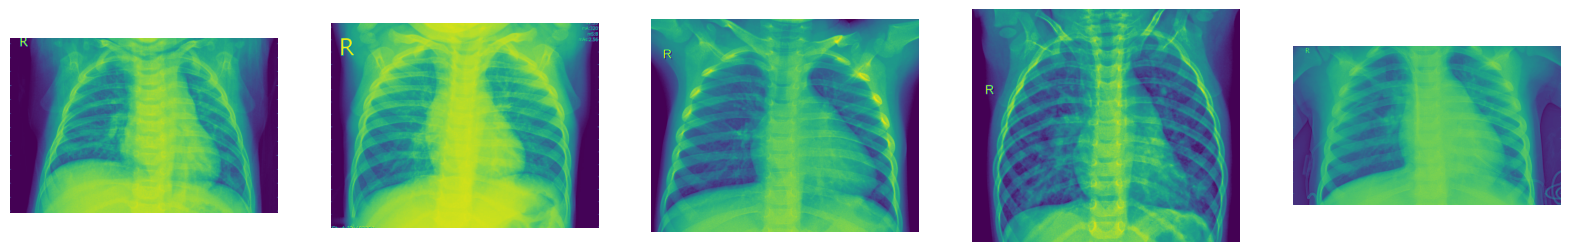

In [ ]:
ReadAndDisplayInputImages(covid_infected_images, 5)

Normal X-Ray Images

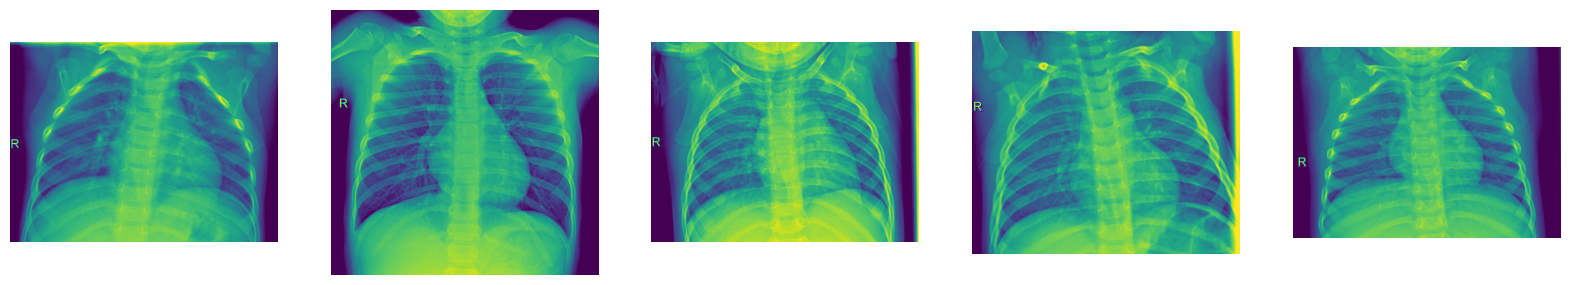

In [ ]:
ReadAndDisplayInputImages(covid_non_infected_images, 5)

Dataframe & Data Labelling

In [ ]:
# create the dataframe
covid_df = pd.DataFrame({
    'filename': covid_infected_images + covid_non_infected_images,
    'label': ['Infected'] * len(covid_infected_images) + ['Normal'] * len(covid_non_infected_images)
})

# Shuffle the rows in the dataset
covid_df = covid_df.sample(frac=1, random_state=34).reset_index(drop=True)

covid_df.head()

,filename,label
0,/content/drive/MyDrive/Covid-19 dataset/Infect...,Infected
1,/content/drive/MyDrive/Covid-19 dataset/Infect...,Infected
2,/content/drive/MyDrive/Covid-19 dataset/Infect...,Infected
3,/content/drive/MyDrive/Covid-19 dataset/Normal...,Normal
4,/content/drive/MyDrive/Covid-19 dataset/Normal...,Normal


Annotated Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


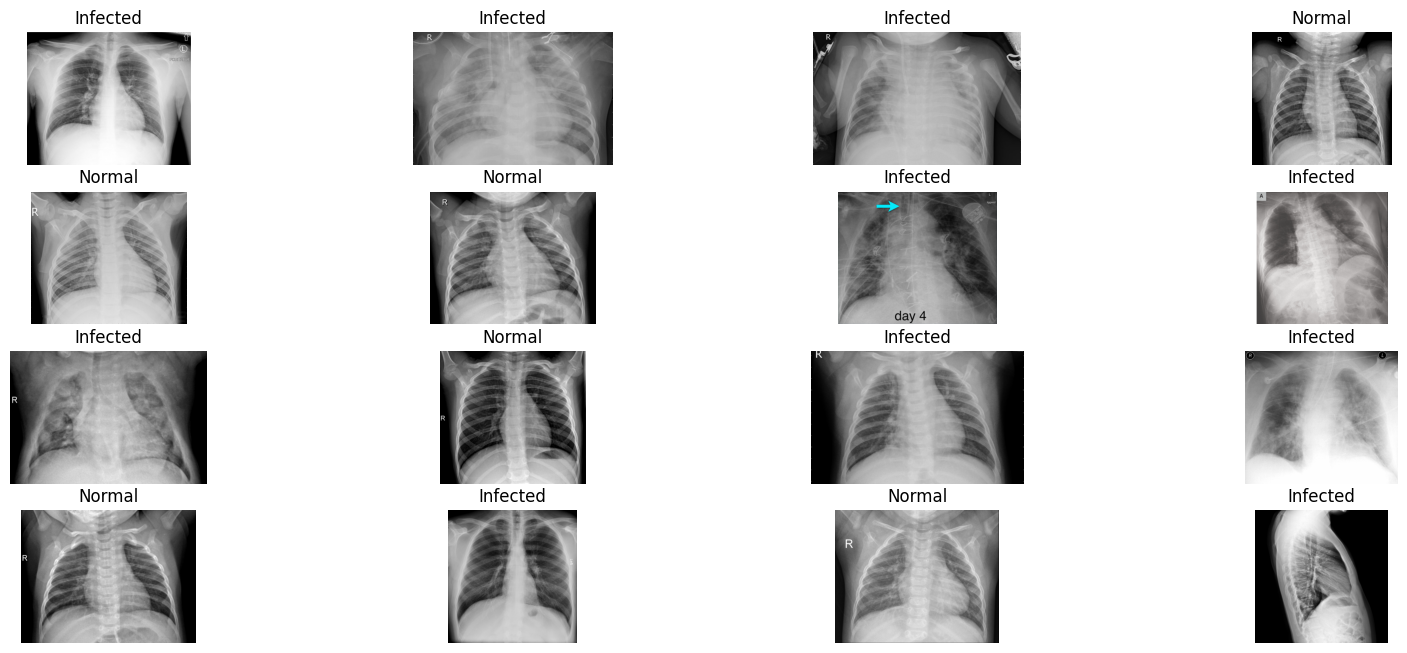

In [ ]:
plt.figure(figsize=(20,10))
columns = 4
numImagesToDisplay = 16

# Read & display the images...
for idx in range(0, numImagesToDisplay):
    plt.subplot(numImagesToDisplay // columns + 1, columns, idx + 1)
    im = img.imread(covid_df.filename[idx])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)
    plt.title(covid_df.label[idx])
    plt.axis('off')

Test - Train - Validation Split

In [ ]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(covid_df['filename'].values,
                                                                      covid_df['label'].values,
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.10, random_state=42)

In [ ]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

print('Training Data:', Counter(train_labels),
      '\n\nValidation Data:', Counter(validation_labels),
      '\n\nTest Data:', Counter(test_labels))

Training Data: Counter({'Infected': 1620, 'Normal': 1179}) 

Validation Data: Counter({'Infected': 186, 'Normal': 126}) 

Test Data: Counter({'Infected': 284, 'Normal': 266})


In [ ]:
print(train_files.shape)
print(test_files.shape)
print(train_labels.shape)
print(test_labels.shape)

(2799,)
(550,)
(2799,)
(550,)


Label Encoding

In [ ]:
# To convert the labels into the binary formabt.
def EncodeLabels(covidLabels):
    encodedLabels = []
    for i in range(0, len(covidLabels)):
        if covidLabels[i] == 'Infected':
            encodedLabels.append(1)
        else:
            encodedLabels.append(0)
    return encodedLabels

y_train = EncodeLabels(train_labels)
y_validation = EncodeLabels(validation_labels)
y_test = EncodeLabels(test_labels)

print('Encoded Training Labels...\n')
print("Categorical Train Labels:", list(train_labels[:5]),
      "\n\nEncoded Train Labels:    ", y_train[:5])

Encoded Training Labels...

Categorical Train Labels: ['Normal', 'Infected', 'Normal', 'Infected', 'Infected'] 

Encoded Train Labels:     [0, 1, 0, 1, 1]


Image Resize

In [ ]:
IMG_RESIZE_DIMS = (224, 224)

train_data = ResizeAllImages(train_files, IMG_RESIZE_DIMS)
validation_data = ResizeAllImages(validation_files, IMG_RESIZE_DIMS)
test_data = ResizeAllImages(test_files, IMG_RESIZE_DIMS)

Model Training Parameters

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 10
INPUT_SHAPE = (224, 224, 3)

Data Augmentation

In [ ]:
# create the data augmentors
train_data_augmentor = ImageDataGenerator(rescale=1./255,
                                          rotation_range=20,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode="nearest")

validation_data_augmentor = ImageDataGenerator(rescale=1./255)

# create the image generators that would yield the
# images on-the-fly during model training phase...
train_gen = train_data_augmentor.flow(train_data, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = validation_data_augmentor.flow(validation_data, y_validation, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
num_train_images = train_gen.n
num_val_images = val_gen.n

print("Number of images in train_gen after augmentation:", num_train_images)
print("Number of images in val_gen after augmentation:", num_val_images)


Number of images in train_gen after augmentation: 2799
Number of images in val_gen after augmentation: 312


Model Creation and Training

In [ ]:
def BuildCustomModelWith(INPUT_SHAPE=(224, 224, 3)):

    model = Sequential(name = 'Custom_Covid-19')

    model.add(Conv2D(32, (3,3), padding='same',input_shape = INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    print(model.summary())
    return model

In [ ]:
model = BuildCustomModelWith()

Model: "Custom_Covid-19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 74, 74, 64)        0         
                                                   

Model Checkpoints

In [ ]:
filepath = './' + model.name + '.keras'
print("Model Checkpoint (.h5 file) Path:", filepath)

Model_Check_Point = ModelCheckpoint(filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             save_weights_only = False,
                             mode = 'auto',
                             save_freq = 'epoch')

Learning_Rate = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, cooldown = 1, verbose = 1)
Early_Stop = EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 1, mode = 'auto')

callback_list = [Model_Check_Point, Learning_Rate]

Model Checkpoint (.h5 file) Path: ./Custom_Covid-19.keras


Train the Model - Model Fit

In [ ]:
train_history = model.fit(train_gen,
                          steps_per_epoch=len(train_data) // BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=val_gen,
                          validation_steps=len(validation_data) // BATCH_SIZE,
                          callbacks=callback_list,
                          verbose=1)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.6220
Epoch 1: val_loss improved from inf to 0.51782, saving model to ./Custom_Covid-19.keras
87/87 [==============================] - 199s 2s/step - loss: 0.6327 - accuracy: 0.6220 - val_loss: 0.5178 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.8135
Epoch 2: val_loss improved from 0.51782 to 0.36950, saving model to ./Custom_Covid-19.keras
87/87 [==============================] - 195s 2s/step - loss: 0.4368 - accuracy: 0.8135 - val_loss: 0.3695 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.8594
Epoch 3: val_loss improved from 0.36950 to 0.32124, saving model to ./Custom_Covid-19.keras
87/87 [==============================] - 206s 2s/step - loss: 0.3457 - accuracy: 0.8594 - val_loss: 0.3212 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 4/10
87/87 

Model Training History

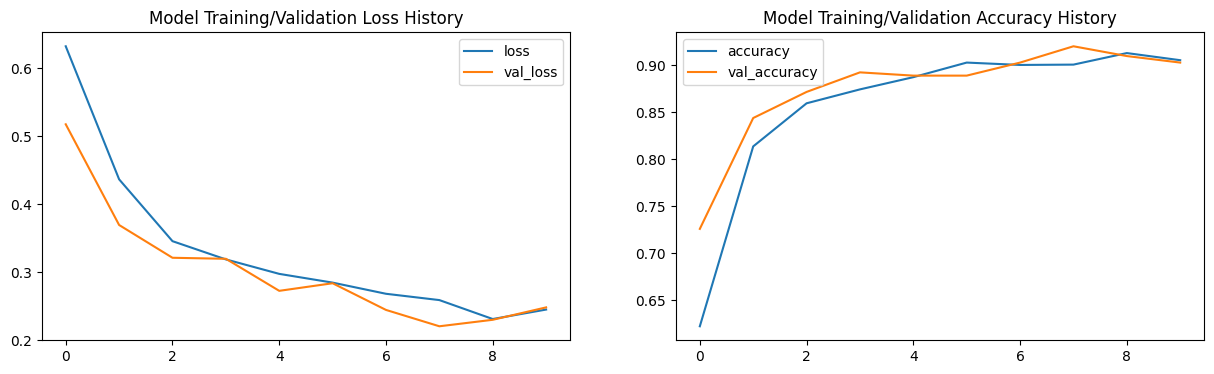

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(train_history.history['loss'])
axes[0].plot(train_history.history['val_loss'])
axes[0].legend(['loss','val_loss'])
axes[0].title.set_text("Model Training/Validation Loss History")

axes[1].plot(train_history.history['accuracy'])
axes[1].plot(train_history.history['val_accuracy'])
axes[1].legend(['accuracy','val_accuracy'])
axes[1].title.set_text("Model Training/Validation Accuracy History")

Model Testing

In [ ]:
X_test = test_data / 255.

In [ ]:
threshold = 0.50

y_preds_probability = model.predict(X_test)
y_preds_binary = [int(pred > threshold) for pred in y_preds_probability]

18/18 [==============================] - 9s 519ms/step


<ipython-input-24-e3ae6b0c7484>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_preds_binary = [int(pred > threshold) for pred in y_preds_probability]


In [ ]:

y_preds_binary = np.where(y_preds_probability > 0.5, 1, 0)  # Assuming threshold of 0.5

# Calculate accuracy
accuracy = np.mean(y_preds_binary == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.5009520661157025


Hyperparameter tunning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2

# Example definitions for required variables
INPUT_SHAPE = (64, 64, 3)  # Example input shape
EPOCHS = 10  # Example number of epochs
BATCH_SIZE = 32  # Example batch size
train_data = np.random.rand(100, 64, 64, 3)  # Example training data
y_train = np.random.randint(2, size=100)  # Example training labels

# Define a function to create the Keras model
def create_model(dropout_rate=0.25, l2_penalty=0.001):
    model = Sequential(name='Custom_Covid-19')
    model.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE, kernel_regularizer=l2(l2_penalty)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(l2_penalty)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(l2_penalty)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_penalty)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the grid of hyperparameters to search
param_grid = {
    'model__dropout_rate': [0.25, 0.5],
    'model__l2_penalty': [0.001, 0.01]
}

# Calculate the total number of combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print("Total combinations to test:", total_combinations)

# Calculate the total number of epochs
total_epochs = EPOCHS * total_combinations
print("Total epochs to run:", total_epochs)

# Create KerasClassifier wrapper for use in GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', error_score='raise')

# Fit the grid search
print("Starting grid search...")
try:
    grid_result = grid.fit(train_data, y_train)
    print("Grid search completed.")

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    # Once you have the best hyperparameters, you can use them to train the final model
    best_dropout_rate = grid_result.best_params_['model__dropout_rate']
    best_l2_penalty = grid_result.best_params_['model__l2_penalty']
except Exception as e:
    print(f"An error occurred: {e}")


Total combinations to test: 4
Total epochs to run: 40
Starting grid search...
An error occurred: 'Sequential' object has no attribute 'compiled'


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a function to create the Keras model
def create_model(dropout_rate=0.25, l2_penalty=0.001):
    model = Sequential(name='Custom_Covid-19')
    model.add(Conv2D(32, (3,3), padding='same', input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define the grid of hyperparameters to search
param_grid = {
    'dropout_rate': [0.25, 0.5],  # Adjust values as needed
    'l2_penalty': [0.001, 0.01]    # Adjust values as needed
}

# Calculate the total number of combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print("Total combinations to test:", total_combinations)

# Calculate the total number of epochs
total_epochs = EPOCHS * total_combinations
print("Total epochs to run:", total_epochs)

# Create KerasClassifier wrapper for use in GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search
print("Starting grid search...")
grid_result = grid.fit(train_data, y_train)
print("Grid search completed.")

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Once you have the best hyperparameters, you can use them to train the final model
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_l2_penalty = grid_result.best_params_['l2_penalty']


Total combinations to test: 4
Total epochs to run: 40
Starting grid search...


ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0.25)`
Check the list of available parameters with `estimator.get_params().keys()`

Transfer learning

In [ ]:
from tensorflow.keras.applications import ResNet50, MobileNet, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define the base model and preprocess_input function for each architecture
base_model_resnet = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
preprocess_input_resnet = tf.keras.applications.resnet.preprocess_input

base_model_mobilenet = MobileNet(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
preprocess_input_mobilenet = tf.keras.applications.mobilenet.preprocess_input

base_model_vgg16 = VGG16(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
preprocess_input_vgg16 = tf.keras.applications.vgg16.preprocess_input

# Function to build model with transfer learning
def build_transfer_learning_model(base_model, preprocess_input):
    # Freeze the base model layers
    base_model.trainable = False

    # Add a global average pooling layer
    global_average_layer = GlobalAveragePooling2D()(base_model.output)

    # Add a dense layer with 128 units
    dense_layer = Dense(128, activation='relu')(global_average_layer)

    # Add the output layer with sigmoid activation for binary classification
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    # Combine the base model and custom layers
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build models for each architecture
model_resnet = build_transfer_learning_model(base_model_resnet, preprocess_input_resnet)
model_mobilenet = build_transfer_learning_model(base_model_mobilenet, preprocess_input_mobilenet)
model_vgg16 = build_transfer_learning_model(base_model_vgg16, preprocess_input_vgg16)

# Train the models
history_resnet = model_resnet.fit(train_gen,
                                  steps_per_epoch=len(train_data) // BATCH_SIZE,
                                  epochs=EPOCHS,
                                  validation_data=val_gen,
                                  validation_steps=len(validation_data) // BATCH_SIZE,
                                  callbacks=callback_list,
                                  verbose=1)

history_mobilenet = model_mobilenet.fit(train_gen,
                                        steps_per_epoch=len(train_data) // BATCH_SIZE,
                                        epochs=EPOCHS,
                                        validation_data=val_gen,
                                        validation_steps=len(validation_data) // BATCH_SIZE,
                                        callbacks=callback_list,
                                        verbose=1)

history_vgg16 = model_vgg16.fit(train_gen,
                                steps_per_epoch=len(train_data) // BATCH_SIZE,
                                epochs=EPOCHS,
                                validation_data=val_gen,
                                validation_steps=len(validation_data) // BATCH_SIZE,
                                callbacks=callback_list,
                                verbose=1)



94765736/94765736 [==============================] - 1s 0us/step


58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.4937
Epoch 1: val_loss did not improve from 0.22034
3/3 [==============================] - 103s 47s/step - loss: 0.7585 - accuracy: 0.4937 - val_loss: 0.6826 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.5938
Epoch 2: val_loss did not improve from 0.22034
3/3 [==============================] - 101s 47s/step - loss: 0.6708 - accuracy: 0.5938 - val_loss: 0.6895 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6354
Epoch 3: val_loss did not improve from 0.22034
3/3 [==============================] - 101s 48s/step - loss: 0.6785 - accuracy: 0.6354 - val_loss: 0.6734 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.5312


-------Evaluating the models on test data

18/18 [==============================] - 307s 17s/step - loss: 0.5750 - accuracy: 0.8473
ResNet Accuracy: 0.585454523563385
MobileNet Accuracy: 0.8836363554000854
VGG16 Accuracy: 0.8472727537155151


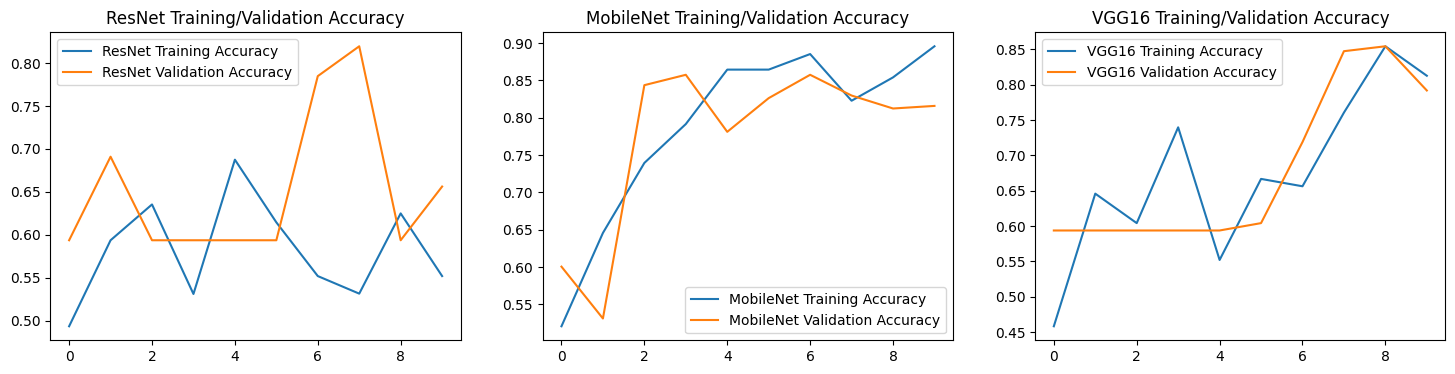

In [ ]:
import numpy as np

# Convert test data to NumPy arrays
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# Evaluate the models on test data
loss_resnet, accuracy_resnet = model_resnet.evaluate(X_test_np, y_test_np)
loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(X_test_np, y_test_np)
loss_vgg16, accuracy_vgg16 = model_vgg16.evaluate(X_test_np, y_test_np)


print("ResNet Accuracy:", accuracy_resnet)
print("MobileNet Accuracy:", accuracy_mobilenet)
print("VGG16 Accuracy:", accuracy_vgg16)

# Plot training history
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
axes[0].plot(history_resnet.history['accuracy'], label='ResNet Training Accuracy')
axes[0].plot(history_resnet.history['val_accuracy'], label='ResNet Validation Accuracy')
axes[0].set_title('ResNet Training/Validation Accuracy')
axes[0].legend()

axes[1].plot(history_mobilenet.history['accuracy'], label='MobileNet Training Accuracy')
axes[1].plot(history_mobilenet.history['val_accuracy'], label='MobileNet Validation Accuracy')
axes[1].set_title('MobileNet Training/Validation Accuracy')
axes[1].legend()

axes[2].plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
axes[2].plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
axes[2].set_title('VGG16 Training/Validation Accuracy')
axes[2].legend()

plt.show()